IMPORTING LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import keras as ks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical



2024-12-06 17:30:47.356118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Visualise 5 random samples

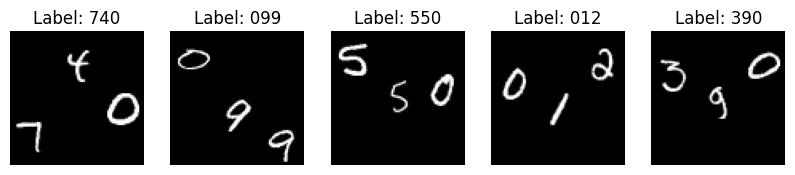

In [73]:
#init image database path
db_path='./triple_mnist/'
db_sets=['val/','train/','test/']

#init images array
imgs=[]

for i in range(5):
    db_set=random.choice(db_sets)

    #combine set with db path
    set_path=db_path+db_set

    #create list of all subfolders in set
    sub_folders=os.listdir(set_path)

    #select random subfolder and get pathname
    subfolder=random.choice(sub_folders)
    subfolder_path = os.path.join(set_path, subfolder)

    #select random image and get pathname
    img=random.choice(os.listdir(subfolder_path))
    img_path=os.path.join(subfolder_path, img)

    #open image and add to array
    img=Image.open(img_path)
    imgs.append((img, subfolder))

#display images using matplotlib
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(imgs, start=1):
    plt.subplot(1, len(imgs), i)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Visualise 5 samples with same label

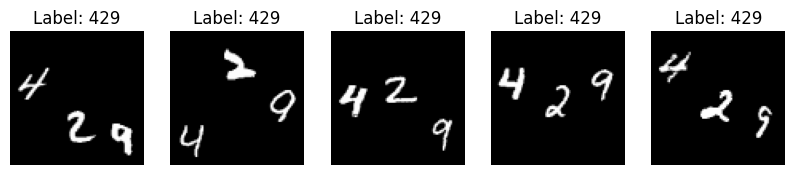

In [74]:
#init images array
imgs=[]
db_sets=['val/','train/','test/']

db_set=random.choice(db_sets)

#combine set with db path
set_path=db_path+db_set

#create list of all subfolders in set
sub_folders=os.listdir(set_path)

#select random subfolder and get pathname
subfolder=random.choice(sub_folders)
subfolder_path = os.path.join(set_path, subfolder)

for i in range(5):
    #select random image and get pathname
    img=random.choice(os.listdir(subfolder_path))
    img_path=os.path.join(subfolder_path, img)

    #open image and add to array
    img=Image.open(img_path)
    imgs.append((img, subfolder))

#display images using matplotlib
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(imgs, start=1):
    plt.subplot(1, len(imgs), i)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

Proof of uniform class distribution

In [79]:
db_path='./triple_mnist/'
label_total = 0

for set in os.listdir(db_path):
    set_path=db_path+set
    for label in os.listdir(set_path):
        subfolder_path = os.path.join(set_path, label)
        if len(os.listdir(subfolder_path)) == 100:
            label_total+=1

print(label_total)


1000


img to array (45 x 45)

In [86]:
db_path='./triple_mnist/'

def flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            flattened_img = (Image.open(img_path)).resize((45, 45))
            flattened_img = (np.array((flattened_img).convert('L')))

            imgs.append(flattened_img)
            labels.append(int(folder))



    return np.array(imgs), np.array(labels)


train_imgs, train_labels = flatten_toarray('train')
test_imgs, test_labels = flatten_toarray('test')
val_imgs, val_labels = flatten_toarray('val')

train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0
val_imgs = val_imgs / 255.0

img to array (84x84)

In [54]:
db_path='./triple_mnist/'

def flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            flattened_img = (Image.open(img_path))
            flattened_img = (np.array((flattened_img).convert('L')))

            imgs.append(flattened_img)
            labels.append(int(folder))
            
    return np.array(imgs), np.array(labels)


f_train_imgs, f_train_labels = flatten_toarray('train')
f_test_imgs, f_test_labels = flatten_toarray('test')
f_val_imgs, f_val_labels = flatten_toarray('val')

f_train_imgs = f_train_imgs / 255.0
f_test_imgs = f_test_imgs / 255.0
f_val_imgs = f_val_imgs / 255.0

combine all splits

In [87]:
all_imgs = np.vstack(((train_imgs, test_imgs, val_imgs)))
all_labels = np.vstack(((train_labels.reshape(train_labels.shape[0], -1), test_labels.reshape(test_labels.shape[0], -1),val_labels.reshape(val_labels.shape[0], -1))))

make seperate splits

In [88]:
sp_train_imgs, sp_test_imgs, sp_train_labels, sp_test_labels = train_test_split(
    all_imgs, all_labels, test_size=0.2, random_state=42
)

sp_train_imgs, sp_val_imgs, sp_train_labels, sp_val_labels = train_test_split(
    sp_train_imgs, sp_train_labels, test_size=0.25, random_state=42
) 

print(f"Training set size: {train_imgs.shape[0]}")
print(f"Validation set size: {val_imgs.shape[0]}")
print(f"Test set size: {test_imgs.shape[0]}")

Training set size: 64000
Validation set size: 16000
Test set size: 20000


Logistic regression with new splits

In [89]:
sp_log_reg = LogisticRegression(max_iter=1000)

sp_log_reg.fit(sp_train_imgs.reshape(sp_train_imgs.shape[0], -1), sp_train_labels)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

Training Accuracy: 0.8231
Validation Accuracy: 0.0000
Test Accuracy: 0.0000



Training Accuracy: 0.4036
Validation Accuracy: 0.0000
Test Accuracy: 0.0000



Training Accuracy: 0.9497
Validation Accuracy: 0.0296
Test Accuracy: 0.0317


logistic regression model with seperate splits

In [91]:
log_reg2 = LogisticRegression(max_iter=1000, C=0.1)

log_reg2.fit(train_imgs.reshape(train_imgs.shape[0], -1), train_labels)

LogisticRegression(C=0.1, max_iter=1000)

In [90]:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(train_imgs.reshape(train_imgs.shape[0], -1), train_labels)

LogisticRegression(max_iter=1000)

In [141]:
# Reshape the test images to match the input format of the model
test_imgs_reshaped = test_imgs.reshape(test_imgs.shape[0], -1)
sp_test_imgs_reshaped = sp_test_imgs.reshape(sp_test_imgs.shape[0], -1)


# Predict the labels for the test data
test_pred = log_reg.predict(test_imgs_reshaped)
test_pred2 = log_reg2.predict(test_imgs_reshaped)
sp_test_pred = sp_log_reg.predict(sp_test_imgs_reshaped)


In [158]:
def get_accuracy(model):
        # Evaluate the model on the training set
        train_score = model.score(train_imgs.reshape(train_imgs.shape[0], -1), train_labels)
        print(f'Training Accuracy: {train_score:.4f}')

        # Evaluate the model on the validation set
        val_score = model.score(val_imgs.reshape(val_imgs.shape[0], -1), val_labels)
        print(f'Validation Accuracy: {val_score:.4f}')

        # Evaluate the model on the test set
        test_score = model.score(test_imgs.reshape(test_imgs.shape[0], -1), test_labels)
        print(f'Test Accuracy: {test_score:.4f}')
def sp_get_accuracy(model):
        # Evaluate the model on the training set
        sp_train_score = model.score(sp_train_imgs.reshape(sp_train_imgs.shape[0], -1), sp_train_labels)
        print(f'Training Accuracy: {sp_train_score:.4f}')

        # Evaluate the model on the validation set
        sp_val_score = model.score(sp_val_imgs.reshape(sp_val_imgs.shape[0], -1), sp_val_labels)
        print(f'Validation Accuracy: {sp_val_score:.4f}')

        # Evaluate the model on the test set
        sp_test_score = model.score(sp_test_imgs.reshape(sp_test_imgs.shape[0], -1), sp_test_labels)
        print(f'Test Accuracy: {sp_test_score:.4f}')

In [ ]:
get_accuracy(log_reg)
print("\n\n")
get_accuracy(log_reg2)
print("\n\n")
sp_get_accuracy(sp_log_reg)

In [128]:
# Convert multi-class predictions to binary (positive = class '0')
def convert_to_binary(predictions, target_class=0):
    return (predictions == target_class).astype(int)

def get_conf_matrix(_test_pred, _test_labels):

    binary_test_pred = convert_to_binary(_test_pred, target_class=0)
    binary_test_labels = convert_to_binary(_test_labels, target_class=0)

    # Generate confusion matrix (binary)
    conf_matrix = confusion_matrix(binary_test_labels, np.ones_like(binary_test_pred))

    # Extract TP, FP, TN, FN
    TP, FP, FN, TN = conf_matrix.ravel()

    # Print the confusion matrix details
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Negatives (FN): {FN}")

    # Calculate accuracy and other metrics
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Binary Confusion Matrix')
    plt.show()

True Positives (TP): 0
False Positives (FP): 19980
True Negatives (TN): 20
False Negatives (FN): 0
Accuracy: 0.0010
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


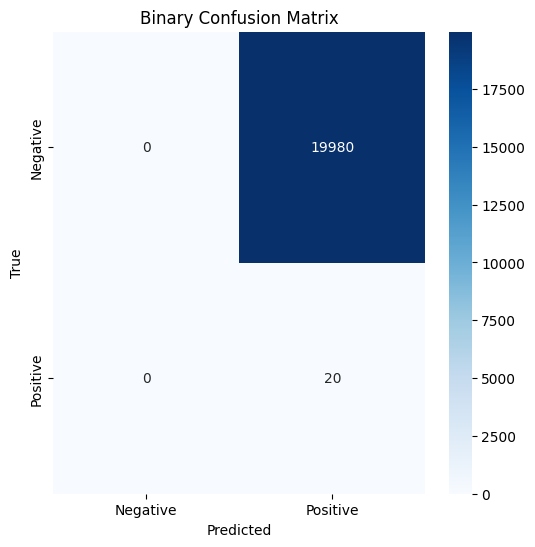

In [139]:
get_conf_matrix(sp_test_pred, sp_test_labels)

TASK 2 CNN

In [118]:
sp_model = models.Sequential()
sp_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 45, 1)))
sp_model.add(layers.MaxPooling2D((2, 2)))
sp_model.add(layers.Flatten())
sp_model.add(layers.Dropout(0.5))
sp_model.add(layers.Dense(100, activation='relu'))
sp_model.add(layers.Dense(1000, activation='softmax'))

In [133]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 45, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1000, activation='softmax'))

In [119]:
# CNN Model Architecture (renamed to model2)
sp_model2 = models.Sequential()

# Conv Layer Block 1
sp_model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 45, 1)))
sp_model2.add(layers.BatchNormalization())
sp_model2.add(layers.MaxPooling2D((2, 2)))
sp_model2.add(layers.Dropout(0.3))

# Conv Layer Block 2
sp_model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
sp_model2.add(layers.BatchNormalization())
sp_model2.add(layers.MaxPooling2D((2, 2)))
sp_model2.add(layers.Dropout(0.3))

# Conv Layer Block 3
sp_model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
sp_model2.add(layers.BatchNormalization())
sp_model2.add(layers.MaxPooling2D((2, 2)))
sp_model2.add(layers.Dropout(0.3))

# Flatten the output of the last convolutional layer
sp_model2.add(layers.Flatten())

# Fully Connected (Dense) Layer
sp_model2.add(layers.Dense(512, activation='relu'))
sp_model2.add(layers.Dropout(0.5))

# Output Layer
sp_model2.add(layers.Dense(1000, activation='softmax'))  

In [120]:
# CNN Model Architecture
model2 = models.Sequential()

# Conv Layer Block 1
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 45, 1)))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.3))

# Conv Layer Block 2
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.3))

# Conv Layer Block 3
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.3))

# Flatten the output of the last convolutional layer
model2.add(layers.Flatten())

# Fully Connected (Dense) Layer
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))

# Output Layer
model2.add(layers.Dense(1000, activation='softmax'))  

In [121]:
sp_cnn_train_imgs = sp_train_imgs[:, :, :, np.newaxis]
sp_cnn_val_imgs = sp_val_imgs[:, :, :, np.newaxis]
sp_cnn_test_imgs = sp_test_imgs[:, :, :, np.newaxis]

'''
print(f"cnn_train_imgs shape: {sp_cnn_train_imgs.shape}")
print(f"cnn_test_imgs shape: {sp_cnn_val_imgs.shape}")
print(sp_train_labels.shape)
print(sp_val_labels.shape)
print(len(sp_train_labels))
'''

cnn_train_imgs shape: (60000, 45, 45, 1)
cnn_test_imgs shape: (20000, 45, 45, 1)
(60000, 1)
(20000, 1)
60000


In [122]:
cnn_train_imgs = train_imgs[:, :, :, np.newaxis]
cnn_val_imgs = val_imgs[:, :, :, np.newaxis]
cnn_test_imgs = test_imgs[:, :, :, np.newaxis]
'''
print(f"cnn_train_imgs shape: {cnn_train_imgs.shape}")
print(f"cnn_test_imgs shape: {cnn_val_imgs.shape}")
print(train_labels.shape)
print(val_labels.shape)
print(len(train_labels))
'''

cnn_train_imgs shape: (64000, 45, 45, 1)
cnn_test_imgs shape: (16000, 45, 45, 1)
(64000,)
(16000,)
64000


In [96]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(cnn_train_imgs, train_labels, epochs=20, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels))

Epoch 1/20
1000/1000 [==============================] - 61s 59ms/step - loss: 5.7064 - accuracy: 0.0269 - val_loss: 22.2815 - val_accuracy: 0.0000e+00
Epoch 2/20
1000/1000 [==============================] - 56s 56ms/step - loss: 3.4140 - accuracy: 0.1893 - val_loss: 30.7007 - val_accuracy: 0.0000e+00
Epoch 3/20
1000/1000 [==============================] - 56s 56ms/step - loss: 2.4572 - accuracy: 0.3481 - val_loss: 32.5630 - val_accuracy: 0.0000e+00
Epoch 4/20
1000/1000 [==============================] - 56s 56ms/step - loss: 1.9876 - accuracy: 0.4527 - val_loss: 32.9285 - val_accuracy: 0.0000e+00
Epoch 5/20
1000/1000 [==============================] - 56s 56ms/step - loss: 1.6917 - accuracy: 0.5249 - val_loss: 34.3128 - val_accuracy: 0.0000e+00
Epoch 6/20
1000/1000 [==============================] - 56s 56ms/step - loss: 1.4792 - accuracy: 0.5759 - val_loss: 34.6490 - val_accuracy: 0.0000e+00
Epoch 7/20
1000/1000 [==============================] - 58s 58ms/step - loss: 1.3186 - accurac

In [117]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model2.fit(cnn_train_imgs, train_labels, epochs=20, batch_size=64,
                    validation_data=(cnn_val_imgs, val_labels))

Epoch 1/20
1000/1000 [==============================] - 138s 136ms/step - loss: 6.5061 - accuracy: 0.0032 - val_loss: 17.2769 - val_accuracy: 0.0000e+00
Epoch 2/20
1000/1000 [==============================] - 159s 159ms/step - loss: 5.8544 - accuracy: 0.0075 - val_loss: 23.2966 - val_accuracy: 0.0000e+00
Epoch 3/20
1000/1000 [==============================] - 156s 156ms/step - loss: 5.4550 - accuracy: 0.0148 - val_loss: 27.1116 - val_accuracy: 0.0000e+00
Epoch 4/20
1000/1000 [==============================] - 158s 158ms/step - loss: 5.2124 - accuracy: 0.0201 - val_loss: 33.0848 - val_accuracy: 0.0000e+00
Epoch 5/20
1000/1000 [==============================] - 157s 157ms/step - loss: 4.9700 - accuracy: 0.0278 - val_loss: 31.8711 - val_accuracy: 0.0000e+00
Epoch 6/20
1000/1000 [==============================] - 157s 157ms/step - loss: 4.7495 - accuracy: 0.0373 - val_loss: 34.3575 - val_accuracy: 0.0000e+00
Epoch 7/20
1000/1000 [==============================] - 154s 154ms/step - loss: 4.

In [201]:
sp_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = sp_model.fit(sp_cnn_train_imgs, sp_train_labels, epochs=20, batch_size=64,
                    validation_data=(sp_cnn_val_imgs, sp_val_labels))

Epoch 1/20
938/938 [==============================] - 58s 60ms/step - loss: 0.7411 - accuracy: 0.7675 - val_loss: 1.8722 - val_accuracy: 0.5286
Epoch 2/20
938/938 [==============================] - 59s 62ms/step - loss: 0.7051 - accuracy: 0.7800 - val_loss: 1.9211 - val_accuracy: 0.5267
Epoch 3/20
938/938 [==============================] - 59s 62ms/step - loss: 0.6776 - accuracy: 0.7870 - val_loss: 1.9310 - val_accuracy: 0.5253
Epoch 4/20
938/938 [==============================] - 55s 59ms/step - loss: 0.6527 - accuracy: 0.7932 - val_loss: 1.9094 - val_accuracy: 0.5289
Epoch 5/20
938/938 [==============================] - 57s 61ms/step - loss: 0.6303 - accuracy: 0.7979 - val_loss: 1.9409 - val_accuracy: 0.5272
Epoch 6/20
938/938 [==============================] - 55s 58ms/step - loss: 0.6045 - accuracy: 0.8073 - val_loss: 1.9430 - val_accuracy: 0.5306
Epoch 7/20
938/938 [==============================] - 58s 62ms/step - loss: 0.5928 - accuracy: 0.8123 - val_loss: 1.9324 - val_accuracy:

In [123]:
sp_model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = sp_model2.fit(sp_cnn_train_imgs, sp_train_labels, epochs=20, batch_size=64,
                    validation_data=(sp_cnn_val_imgs, sp_val_labels))

Epoch 1/20
938/938 [==============================] - 157s 165ms/step - loss: 6.9314 - accuracy: 7.6667e-04 - val_loss: 7.0110 - val_accuracy: 9.0000e-04
Epoch 2/20
938/938 [==============================] - 132s 141ms/step - loss: 6.9083 - accuracy: 7.8333e-04 - val_loss: 6.9760 - val_accuracy: 5.0000e-04
Epoch 3/20
938/938 [==============================] - 131s 140ms/step - loss: 6.9079 - accuracy: 8.1667e-04 - val_loss: 7.6201 - val_accuracy: 6.5000e-04
Epoch 4/20
938/938 [==============================] - 135s 144ms/step - loss: 6.9071 - accuracy: 0.0010 - val_loss: 7.0013 - val_accuracy: 5.5000e-04
Epoch 5/20
938/938 [==============================] - 136s 145ms/step - loss: 6.9079 - accuracy: 0.0012 - val_loss: 6.9187 - val_accuracy: 8.0000e-04
Epoch 6/20
938/938 [==============================] - 137s 146ms/step - loss: 6.9067 - accuracy: 0.0011 - val_loss: 7.0897 - val_accuracy: 9.5000e-04
Epoch 7/20
938/938 [==============================] - 701s 748ms/step - loss: 6.9066 - a

In [126]:
# Get predictions
predictions = model.predict(cnn_test_imgs)
sp_predictions = sp_model.predict(sp_cnn_test_imgs)
predictions2 = model2.predict(cnn_test_imgs)
sp_predictions2 = sp_model2.predict(sp_cnn_test_imgs)


625/625 [==============================] - 14s 22ms/step


In [227]:
def get_stats(preds, _test_labels):
    # Convert predictions to class labels (multiclass prediction to single class index)
    predicted_labels = np.argmax(preds, axis=1)

    if len(_test_labels.shape) != 1:
        true_labels = np.argmax(_test_labels, axis=1)
    else:
        true_labels = _test_labels

    # Convert to binary classification
    # Correctly predicted = 1, Incorrectly predicted = 0
    binary_predictions = (predicted_labels == true_labels).astype(int)

    # True binary labels
    binary_true_labels = np.ones_like(binary_predictions)  # True labels are all "correct" (1)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(binary_true_labels, binary_predictions, labels=[0, 1])

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Compute F1 Score (macro-average across classes)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro Average): {f1:.4f}")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect (0)', 'Correct (1)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Binary Confusion Matrix for Model Predictions')
    plt.show()


Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


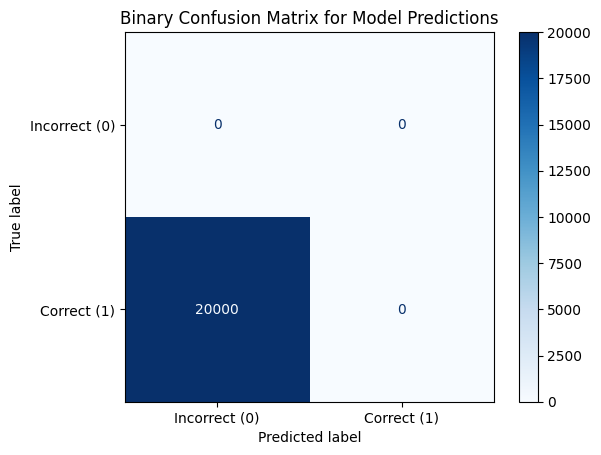

In [223]:
get_stats(predictions,test_labels)

Accuracy: 0.0008
F1 Score (Macro Average): 0.0002


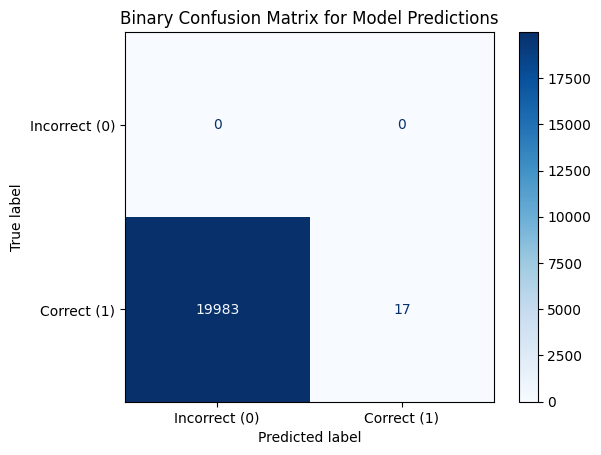

In [224]:
get_stats(predictions2, test_labels)

Accuracy: 0.0003
F1 Score (Macro Average): 0.0000


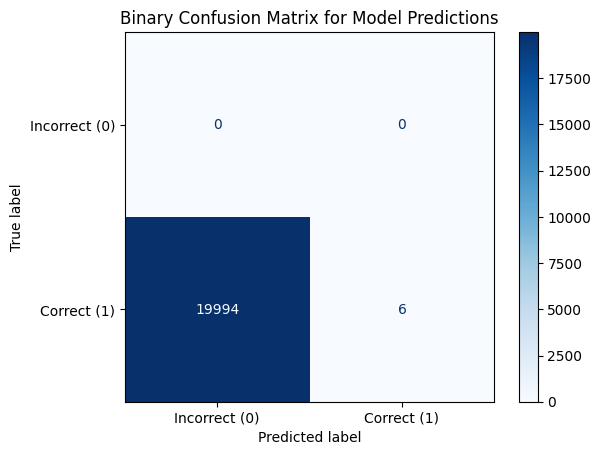

In [225]:
get_stats(sp_predictions, sp_test_labels)

Accuracy: 0.0000
F1 Score (Macro Average): 0.0000


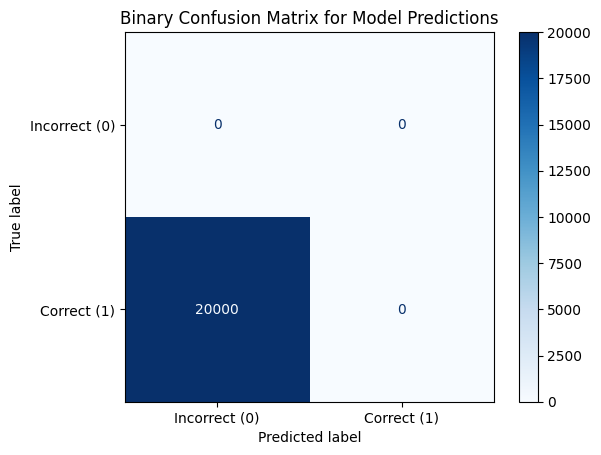

In [226]:
get_stats(sp_predictions2, sp_test_labels)

In [324]:
# Function to display grid of images with their predictions
def display_prediction_grid(true_false, original_images, y_true, y_pred, num_samples=25):

    try:
        y_pred = np.argmax(y_pred, axis=1)
    except Exception as e:
        pass

    if (true_false):
        indices = np.where((test_labels == y_pred))[0]
        title = "Correct Preditions"
    else:
        indices = np.where((test_labels != y_pred))[0]
        title = "Incorrect Preditions"


    # Select a random sample if there are more than num_samples
    if len(indices) > num_samples:
        sample_indices = np.random.choice(indices, num_samples, replace=False)
    else:
        sample_indices = indices
    
    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(len(sample_indices))))
    
    plt.figure(figsize=(20, 20))
    for idx, i in enumerate(sample_indices):
        plt.subplot(grid_size, grid_size, idx + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title(f'True: {y_true[i]}\nPred: {y_pred[i]}')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


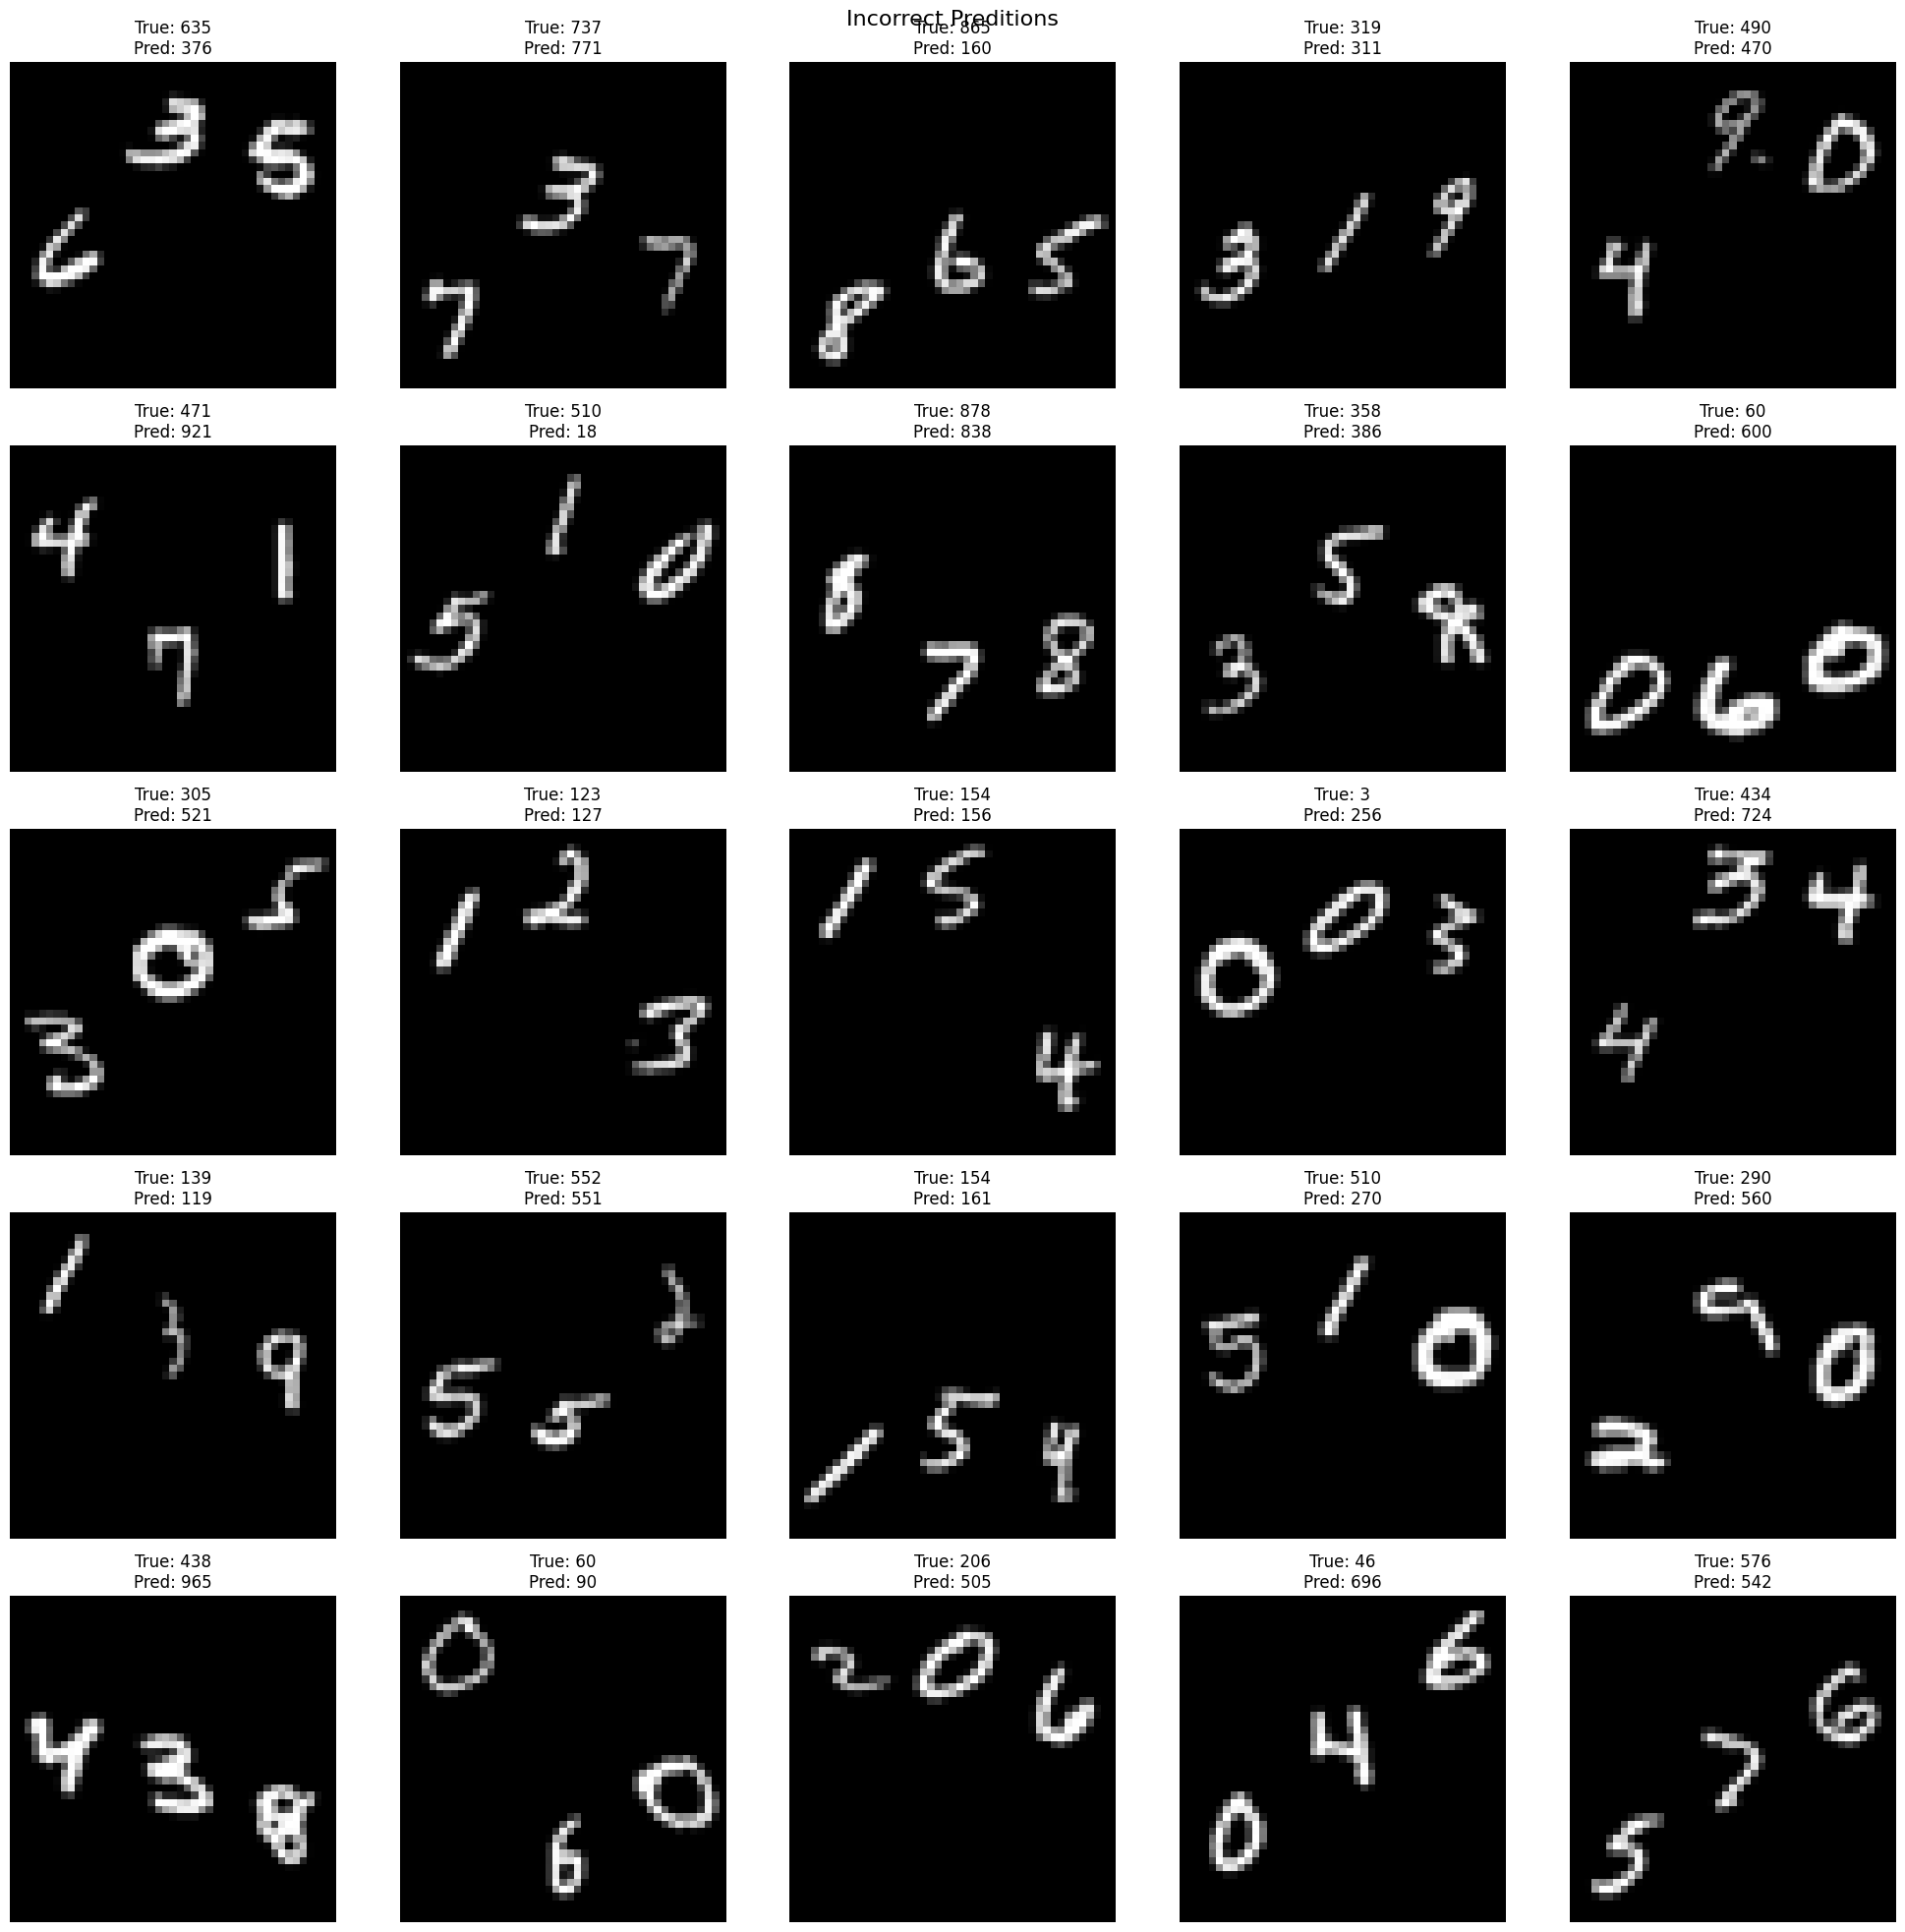

In [325]:
display_prediction_grid(False, test_imgs, test_labels, test_pred)


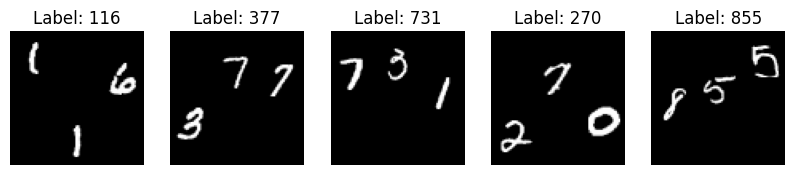

In [230]:
#init image database path
db_path='./triple_mnist/'
db_sets=['val/','train/','test/']

#init images array
imgs=[]

for i in range(5):
    db_set=random.choice(db_sets)

    #combine set with db path
    set_path=db_path+db_set

    #create list of all subfolders in set
    sub_folders=os.listdir(set_path)

    subfolder=random.choice(sub_folders)
    subfolder_path = os.path.join(set_path, subfolder)

    #select random image and get pathname
    img=random.choice(os.listdir(subfolder_path))
    img_path=os.path.join(subfolder_path, img)

    #open image and add to array
    img=Image.open(img_path)
    imgs.append((img, subfolder))
    
#display images using matplotlib
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(imgs, start=1):
    plt.subplot(1, len(imgs), i)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()


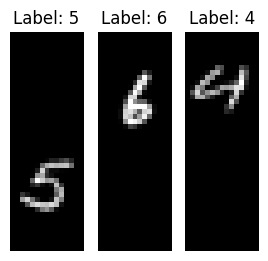

In [248]:
db_set=random.choice(db_sets)

#combine set with db path
set_path=db_path+db_set

#create list of all subfolders in set
sub_folders=os.listdir(set_path)

subfolder=random.choice(sub_folders)
subfolder_path = os.path.join(set_path, subfolder)

#select random image and get pathname
img=random.choice(os.listdir(subfolder_path))
test_img_path=os.path.join(subfolder_path, img)

test_img=Image.open(test_img_path).convert('L').resize((45,45))

split_width = test_img.size[0] // 3

test_splits= [
    test_img.crop((i * split_width, 0 , (i+1) * split_width, test_img.size[1]))
    for i in range(3)
]

plt.figure(figsize=(10,3))
for i, split in enumerate(test_splits):
    plt.subplot(1, 9, i+1)
    plt.imshow(test_splits[i], cmap='gray')
    plt.title(f'Label: {subfolder[i]}')
    plt.axis('off')

plt.show()


In [200]:
db_path='./triple_mnist/'

def splits_flatten_toarray(set):
    set_path=db_path+set
    sub_folders=os.listdir(set_path)

    imgs=[]
    labels=[]

    for folder in sub_folders:
        subfolder_path = os.path.join(set_path, folder)

        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)

            img = Image.open(img_path).convert('L').resize((45,45))
            
            width, height = img.size
            
            split_width = width // 3

            splits = [
                img.crop((i * split_width, 0, (i + 1) * split_width, height))
                for i in range(3)
            ]

            for i, split in enumerate(splits):
                imgs.append(np.array(split))  
                labels.append(int(folder[i]))

    return np.array(imgs), np.array(labels)


t_train_imgs, t_train_labels = splits_flatten_toarray('train')
t_test_imgs, t_test_labels = splits_flatten_toarray('test')
t_val_imgs, t_val_labels = splits_flatten_toarray('val')

t_train_imgs = t_train_imgs / 255.0
t_test_imgs = t_test_imgs / 255.0
t_val_imgs = t_val_imgs / 255.0

In [249]:
print(t_train_imgs.shape)

(192000, 45, 15)


In [250]:
def build_cnn_basic():
    t_model = models.Sequential()
    t_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(45, 15, 1)))
    t_model.add(layers.MaxPooling2D((2, 2)))

    t_model.add(layers.Flatten())
    t_model.add(layers.Dropout(0.5))
    t_model.add(layers.Dense(100, activation='relu'))
    t_model.add(layers.Dense(10, activation='softmax'))

    t_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # compile model
    return t_model

In [251]:
def build_cnn_comp():
   # CNN Model Architecture (Adjusted Padding)
    model2 = models.Sequential()

    # Conv Layer Block 1
    model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(45, 15, 1)))
    model2.add(layers.BatchNormalization())
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Dropout(0.3))

    # Conv Layer Block 2
    model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Dropout(0.3))

    # Conv Layer Block 3
    model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Dropout(0.3))

    # Flatten the output of the last convolutional layer
    model2.add(layers.Flatten())

    # Fully Connected (Dense) Layer
    model2.add(layers.Dense(512, activation='relu'))
    model2.add(layers.Dropout(0.5))

    # Output Layer
    model2.add(layers.Dense(10, activation='softmax'))  

   #  model2.summary()
    model2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # compile model
    return model2

In [252]:
t_train_imgs = t_train_imgs[:, :, :, np.newaxis]
t_val_imgs = t_val_imgs[:, :, :, np.newaxis]
t_test_imgs = t_test_imgs[:, :, :, np.newaxis]

'''
print(f"t_train_imgs shape: {t_train_imgs.shape}")
print(f"t_test_imgs shape: {t_val_imgs.shape}")


print(t_train_labels.shape)
print(t_val_labels.shape)

print(len(t_train_labels))
'''


'\nprint(f"t_train_imgs shape: {t_train_imgs.shape}")\nprint(f"t_test_imgs shape: {t_val_imgs.shape}")\n\n\nprint(t_train_labels.shape)\nprint(t_val_labels.shape)\n\nprint(len(t_train_labels))\n'

In [ ]:
t_models = []
for i in range(3):
    print(f"Training model for digit {i+1}")
    t_model = build_cnn_comp()
    t_model.fit(t_train_imgs[i::3], t_train_labels[i::3], epochs=10,
              validation_data=(t_val_imgs[i::3], t_val_labels[i::3]))
    t_models.append(t_model)

Training model for digit 1
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 45, 15, 32)        320       
                                                                 
 batch_normalization_10 (Ba  (None, 45, 15, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 22, 7, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 22, 7, 32)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 22, 7, 64)         18496     
                                                                 
 batch_normalization_11 (B

In [ ]:
predictions = []
for i, model in enumerate(t_models):
    preds = np.argmax(model.predict(t_test_imgs[i::3]), axis=1)
    predictions.append(preds)

all_preds = np.array(predictions).T

625/625 [==============================] - 9s 15ms/step


In [477]:
# Combine true labels into a single array for comparison
test_labels_combined = np.array([int(str(label).zfill(3)) for label in t_test_labels])
predicted_labels_combined = np.array([int("".join(map(str, pred))) for pred in all_preds])

# Metrics
accuracy = accuracy_score(test_labels, predicted_labels_combined)
f1 = f1_score(test_labels, predicted_labels_combined, average='macro')
conf_matrix = confusion_matrix(test_labels, predicted_labels_combined)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
# print("Confusion Matrix:")
# print(conf_matrix)


Accuracy: 0.9640
F1 Score: 0.3621


In [476]:
print(test_labels_combined.shape)
print(predicted_labels_combined.shape)

(60000,)
(20000,)


Test loss: [0.05998226 0.04044513 0.03359785]
Test accuracy: [0.98570001 0.98834997 0.9896    ]
Accuracy: 0.9640
F1 Score (Macro Average): 0.3621


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

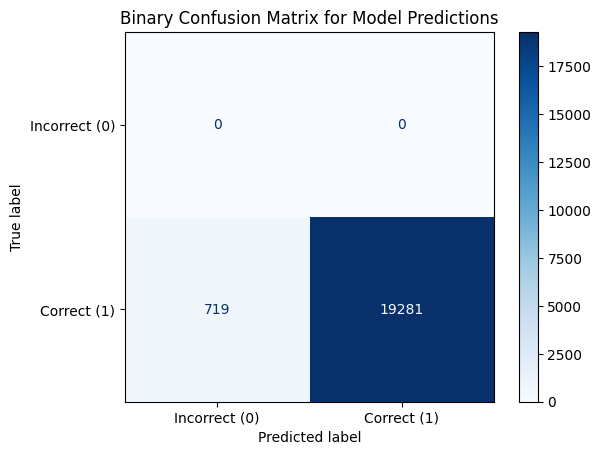

In [ ]:
evals = []
for i, model in enumerate(t_models):
    eval = model.evaluate(t_test_imgs[i::3], t_test_labels[i::3], verbose=0)
    evals.append(eval)

score = np.array(evals).T

print("Test loss:", score[0])
print("Test accuracy:", score[1])


# Correctly predicted = 1, Incorrectly predicted = 0
binary_predictions = (predicted_labels_combined == test_labels).astype(int)

# True binary labels
binary_true_labels = np.ones_like(binary_predictions)  # True labels are all "correct" (1)

# Compute confusion matrix
conf_matrix = confusion_matrix(binary_true_labels, binary_predictions, labels=[0, 1])

# Compute accuracy
accuracy = accuracy_score(test_labels, predicted_labels_combined)

# Compute F1 Score (macro-average across classes)
f1 = f1_score(test_labels, predicted_labels_combined, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro Average): {f1:.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Incorrect (0)', 'Correct (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Binary Confusion Matrix for Model Predictions')
plt.show()


In [501]:
reshaped_labels = t_test_labels.reshape(-1, 3)

comb_test_labels = np.array([int("".join(map(str, group))) for group in reshaped_labels])

print(comb_test_labels.shape)


(20000,)
[135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135 135
 135 135 135 135 135 135 135]


In [502]:
y_test = comb_test_labels
y_pred = predicted_labels_combined
X_test = test_imgs


In [254]:
true_positive_indices = np.where((y_test == y_pred))[0]
false_positive_indices = np.where((y_test != y_pred))[0]

# Function to display grid of images with their predictions
def display_prediction_grid(indices, original_images, y_true, y_pred, title, num_samples=25):
    # Select a random sample if there are more than num_samples
    if len(indices) > num_samples:
        sample_indices = np.random.choice(indices, num_samples, replace=False)
    else:
        sample_indices = indices
    
    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(len(sample_indices))))
    
    plt.figure(figsize=(20, 20))
    for idx, i in enumerate(sample_indices):
        plt.subplot(grid_size, grid_size, idx + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title(f'True: {y_true[i]}\nPred: {y_pred[i]}')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display true positives
print(f"\nDisplaying {min(25, len(true_positive_indices))} True Positives (Correct Classifications)")
display_prediction_grid(true_positive_indices, X_test, y_test, y_pred, 
                      'True Positives (Correct Classifications)')

# Display false positives
print(f"\nDisplaying {min(25, len(false_positive_indices))} False Positives (Incorrect Classifications)")
display_prediction_grid(false_positive_indices, X_test, y_test, y_pred,
                      'False Positives (Incorrect Classifications)')

# Print some statistics
print("\nSummary Statistics:")
print(f"Total True Positives: {len(true_positive_indices)}")
print(f"Total False Positives: {len(false_positive_indices)}")

# Show a few specific examples with their digit-by-digit predictions
print("\nDetailed Analysis of Some False Positives:")
for idx in false_positive_indices[:5]:
    true_hundreds, true_tens, true_ones = y_test[idx] // 100, (y_test[idx] % 100) // 10, y_test[idx] % 10
    pred_hundreds, pred_tens, pred_ones = y_pred[idx] // 100, (y_pred[idx] % 100) // 10, y_pred[idx] % 10
    
    print(f"\nImage {idx}:")
    print(f"True number: {y_test[idx]} ({true_hundreds}-{true_tens}-{true_ones})")
    print(f"Predicted: {y_pred[idx]} ({pred_hundreds}-{pred_tens}-{pred_ones})")



NameError: name 'y_test' is not defined

In [ ]:
print(t_test_imgs.shape)
print(t_test_labels.shape)

print(t_train_imgs.shape)
print(t_train_labels.shape)

t_train_imgs_reshaped = t_train_imgs.reshape(192000, 675)
print(t_train_imgs_reshaped.shape)

nt_train_imgs = (t_train_imgs - 0.5) / 0.5  # Normalize to [-1, 1] range for GAN

nt_train_imgs_re = nt_train_imgs.reshape(192000, 675)

print(nt_train_imgs.shape)



(60000, 45, 15, 1, 1)
(60000,)
(192000, 45, 15, 1, 1)
(192000,)
(192000, 675)
(192000, 45, 15, 1, 1)


In [ ]:
print(train_imgs.shape)

n_train_imgs= (train_imgs - 0.5) / 0.5
n_train_imgs= train_imgs.reshape(64000, 2025)

print(n_train_imgs.shape)

(64000, 45, 45)


(64000, 2025)


In [442]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


In [13]:
def generate_and_visualize(generator, latent_dim, num_images=16):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = generator(noise)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]
    
    # Visualize
    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()


In [55]:
##NO CONV

def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim),
        layers.BatchNormalization(), # ON FOR 45x45, off for 45x15
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        # layers.Dense(45 * 45 * 1, activation='tanh'), #SHAPE
        # layers.Reshape((45, 45, 1)) #SHAPE

        layers.Dense(84 * 84 * 1, activation='tanh'), #SHAPE
        layers.Reshape((84, 84, 1)) #SHAPE

        # layers.Dense(45 * 15 * 1, activation='tanh'), #SHAPE
        # layers.Reshape((45, 15, 1)) #SHAPE

        # layers.Dense(28 * 28 * 1, activation='tanh'), #SHAPE
        # layers.Reshape((28, 28, 1)) #SHAPE
    ])
    return model

# Define the Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(84, 84, 1)), #SHAPE

        # layers.Flatten(input_shape=(45, 45, 1)), #SHAPE

        # layers.Flatten(input_shape=(28, 28, 1)), #SHAPE

        # layers.Flatten(input_shape=(45, 15, 1)), #SHAPE

        layers.Dense(1024, activation='relu'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential([generator, discriminator]) 

In [63]:
def build_generator(z_dim=100):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim),
        layers.BatchNormalization(), # ON FOR 45x45, off for 45x15
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        # layers.Dense(45 * 45 * 1, activation='tanh'), #SHAPE
        # layers.Reshape((45, 45, 1)) #SHAPE

        layers.Dense(84 * 84 * 1, activation='tanh'), #SHAPE
        layers.Reshape((84, 84, 1)) #SHAPE

        # layers.Dense(45 * 15 * 1, activation='tanh'), #SHAPE
        # layers.Reshape((45, 15, 1)) #SHAPE

        # layers.Dense(28 * 28 * 1, activation='tanh'), #SHAPE
        # layers.Reshape((28, 28, 1)) #SHAPE
    ])
    return model


def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(84,84,1)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model




# GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential([generator, discriminator])
    return model

In [4]:
def train_gan(generator, discriminator, gan, train_images, latent_dim, epochs, batch_size, display_interval):
    """
    Train the GAN model with real and synthetic data while displaying progress.
    Outputs generator and discriminator loss at each epoch.
    """
    for epoch in range(epochs):
        # Train discriminator
        real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]
        real_labels = np.ones((batch_size, 1))
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
        # Print losses for each epoch
        print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]*100:.2f}%, G Loss: {g_loss:.4f}")

        if epoch % 100 == 0:
            generate_and_visualize(generator, latent_dim)



In [64]:
# Hyperparameters
latent_dim = 100  # Size of the noise vector
batch_size = 64
epochs = 2500
display_interval = 1000

# Instantiate models
generator = build_generator(latent_dim)
discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

2/2 [==============================] - 0s 10ms/step
Epoch 1/2500 - D Loss: 0.6922, D Acc: 42.97%, G Loss: 0.6936


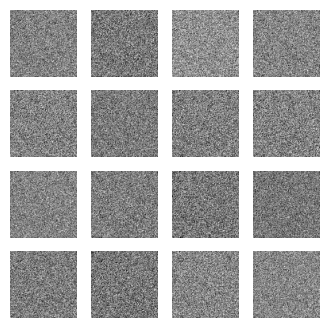

2/2 [==============================] - 0s 5ms/step
Epoch 2/2500 - D Loss: 0.6953, D Acc: 37.50%, G Loss: 0.6759
2/2 [==============================] - 0s 5ms/step
Epoch 3/2500 - D Loss: 0.7002, D Acc: 40.62%, G Loss: 0.6637
2/2 [==============================] - 0s 6ms/step
Epoch 4/2500 - D Loss: 0.6992, D Acc: 48.44%, G Loss: 0.6499
2/2 [==============================] - 0s 6ms/step
Epoch 5/2500 - D Loss: 0.7042, D Acc: 48.44%, G Loss: 0.6369
2/2 [==============================] - 0s 5ms/step
Epoch 6/2500 - D Loss: 0.7059, D Acc: 50.00%, G Loss: 0.6262
2/2 [==============================] - 0s 6ms/step
Epoch 7/2500 - D Loss: 0.7097, D Acc: 50.00%, G Loss: 0.6139
2/2 [==============================] - 0s 8ms/step
Epoch 8/2500 - D Loss: 0.7130, D Acc: 50.00%, G Loss: 0.6012
2/2 [==============================] - 0s 6ms/step
Epoch 9/2500 - D Loss: 0.7135, D Acc: 50.00%, G Loss: 0.5926
2/2 [==============================] - 0s 70ms/step
Epoch 10/2500 - D Loss: 0.7155, D Acc: 50.00%, G Los

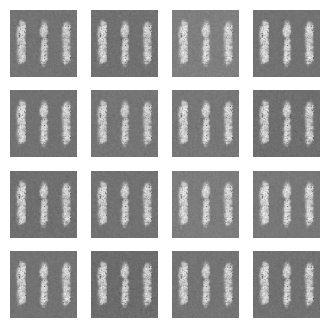

2/2 [==============================] - 0s 7ms/step
Epoch 102/2500 - D Loss: 0.2275, D Acc: 100.00%, G Loss: 2.7587
2/2 [==============================] - 0s 5ms/step
Epoch 103/2500 - D Loss: 0.2452, D Acc: 99.22%, G Loss: 2.5712
2/2 [==============================] - 0s 5ms/step
Epoch 104/2500 - D Loss: 0.2269, D Acc: 100.00%, G Loss: 2.6569
2/2 [==============================] - 0s 8ms/step
Epoch 105/2500 - D Loss: 0.2227, D Acc: 98.44%, G Loss: 2.6549
2/2 [==============================] - 0s 5ms/step
Epoch 106/2500 - D Loss: 0.2279, D Acc: 99.22%, G Loss: 2.6953
2/2 [==============================] - 0s 6ms/step
Epoch 107/2500 - D Loss: 0.2665, D Acc: 95.31%, G Loss: 2.4990
2/2 [==============================] - 0s 6ms/step
Epoch 108/2500 - D Loss: 0.2750, D Acc: 97.66%, G Loss: 2.4306
2/2 [==============================] - 0s 7ms/step
Epoch 109/2500 - D Loss: 0.2375, D Acc: 100.00%, G Loss: 2.7354
2/2 [==============================] - 0s 5ms/step
Epoch 110/2500 - D Loss: 0.2816, D

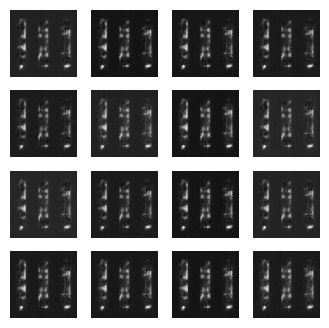

2/2 [==============================] - 0s 8ms/step
Epoch 202/2500 - D Loss: 0.1615, D Acc: 100.00%, G Loss: 2.1620
2/2 [==============================] - 0s 6ms/step
Epoch 203/2500 - D Loss: 0.1667, D Acc: 100.00%, G Loss: 2.1671
2/2 [==============================] - 0s 6ms/step
Epoch 204/2500 - D Loss: 0.1823, D Acc: 100.00%, G Loss: 2.1097
2/2 [==============================] - 0s 7ms/step
Epoch 205/2500 - D Loss: 0.1827, D Acc: 100.00%, G Loss: 1.9138
2/2 [==============================] - 0s 5ms/step
Epoch 206/2500 - D Loss: 0.1843, D Acc: 100.00%, G Loss: 1.9655
2/2 [==============================] - 0s 5ms/step
Epoch 207/2500 - D Loss: 0.2064, D Acc: 100.00%, G Loss: 1.9558
2/2 [==============================] - 0s 5ms/step
Epoch 208/2500 - D Loss: 0.1811, D Acc: 100.00%, G Loss: 2.0141
2/2 [==============================] - 0s 6ms/step
Epoch 209/2500 - D Loss: 0.2055, D Acc: 98.44%, G Loss: 2.0780
2/2 [==============================] - 0s 5ms/step
Epoch 210/2500 - D Loss: 0.214

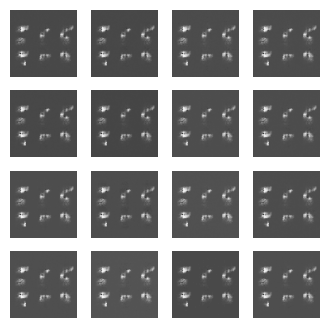

2/2 [==============================] - 0s 7ms/step
Epoch 302/2500 - D Loss: 0.0751, D Acc: 98.44%, G Loss: 2.9871
2/2 [==============================] - 0s 6ms/step
Epoch 303/2500 - D Loss: 0.0623, D Acc: 100.00%, G Loss: 3.2738
2/2 [==============================] - 0s 9ms/step
Epoch 304/2500 - D Loss: 0.1236, D Acc: 96.09%, G Loss: 2.8623
2/2 [==============================] - 0s 5ms/step
Epoch 305/2500 - D Loss: 0.0878, D Acc: 99.22%, G Loss: 2.8806
2/2 [==============================] - 0s 6ms/step
Epoch 306/2500 - D Loss: 0.0984, D Acc: 98.44%, G Loss: 3.0120
2/2 [==============================] - 0s 6ms/step
Epoch 307/2500 - D Loss: 0.1280, D Acc: 96.09%, G Loss: 3.2060
2/2 [==============================] - 0s 5ms/step
Epoch 308/2500 - D Loss: 0.1714, D Acc: 94.53%, G Loss: 2.9866
2/2 [==============================] - 0s 6ms/step
Epoch 309/2500 - D Loss: 0.1590, D Acc: 95.31%, G Loss: 2.9182
2/2 [==============================] - 0s 5ms/step
Epoch 310/2500 - D Loss: 0.2076, D A

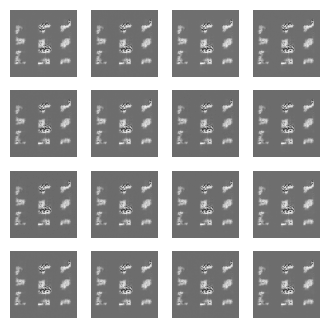

2/2 [==============================] - 0s 9ms/step
Epoch 402/2500 - D Loss: 0.0543, D Acc: 98.44%, G Loss: 3.7253
2/2 [==============================] - 0s 5ms/step
Epoch 403/2500 - D Loss: 0.0517, D Acc: 99.22%, G Loss: 3.4935
2/2 [==============================] - 0s 5ms/step
Epoch 404/2500 - D Loss: 0.0564, D Acc: 100.00%, G Loss: 3.1898
2/2 [==============================] - 0s 8ms/step
Epoch 405/2500 - D Loss: 0.0570, D Acc: 99.22%, G Loss: 3.3725
2/2 [==============================] - 0s 5ms/step
Epoch 406/2500 - D Loss: 0.0382, D Acc: 100.00%, G Loss: 3.8421
2/2 [==============================] - 0s 6ms/step
Epoch 407/2500 - D Loss: 0.0360, D Acc: 100.00%, G Loss: 4.2836
2/2 [==============================] - 0s 6ms/step
Epoch 408/2500 - D Loss: 0.0370, D Acc: 99.22%, G Loss: 4.2822
2/2 [==============================] - 0s 6ms/step
Epoch 409/2500 - D Loss: 0.0479, D Acc: 99.22%, G Loss: 3.9330
2/2 [==============================] - 0s 7ms/step
Epoch 410/2500 - D Loss: 0.0375, D

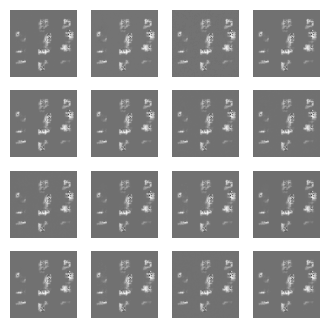

2/2 [==============================] - 0s 6ms/step
Epoch 502/2500 - D Loss: 0.0410, D Acc: 100.00%, G Loss: 3.7527
2/2 [==============================] - 0s 6ms/step
Epoch 503/2500 - D Loss: 0.0423, D Acc: 100.00%, G Loss: 3.8314
2/2 [==============================] - 0s 5ms/step
Epoch 504/2500 - D Loss: 0.0520, D Acc: 100.00%, G Loss: 3.4773
2/2 [==============================] - 0s 5ms/step
Epoch 505/2500 - D Loss: 0.0441, D Acc: 99.22%, G Loss: 3.8124
2/2 [==============================] - 0s 5ms/step
Epoch 506/2500 - D Loss: 0.0673, D Acc: 98.44%, G Loss: 3.7811
2/2 [==============================] - 0s 6ms/step
Epoch 507/2500 - D Loss: 0.0428, D Acc: 98.44%, G Loss: 4.0631
2/2 [==============================] - 0s 6ms/step
Epoch 508/2500 - D Loss: 0.0456, D Acc: 100.00%, G Loss: 3.8263
2/2 [==============================] - 0s 6ms/step
Epoch 509/2500 - D Loss: 0.0577, D Acc: 100.00%, G Loss: 3.6706
2/2 [==============================] - 0s 5ms/step
Epoch 510/2500 - D Loss: 0.0413,

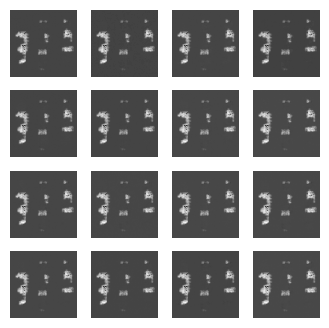

2/2 [==============================] - 0s 10ms/step
Epoch 602/2500 - D Loss: 0.0397, D Acc: 99.22%, G Loss: 3.9475
2/2 [==============================] - 0s 5ms/step
Epoch 603/2500 - D Loss: 0.0174, D Acc: 100.00%, G Loss: 4.0578
2/2 [==============================] - 0s 5ms/step
Epoch 604/2500 - D Loss: 0.0228, D Acc: 100.00%, G Loss: 4.0224
2/2 [==============================] - 0s 5ms/step
Epoch 605/2500 - D Loss: 0.0304, D Acc: 99.22%, G Loss: 4.1154
2/2 [==============================] - 0s 5ms/step
Epoch 606/2500 - D Loss: 0.0190, D Acc: 100.00%, G Loss: 4.1456
2/2 [==============================] - 0s 5ms/step
Epoch 607/2500 - D Loss: 0.0234, D Acc: 100.00%, G Loss: 4.2213
2/2 [==============================] - 0s 5ms/step
Epoch 608/2500 - D Loss: 0.0401, D Acc: 97.66%, G Loss: 3.8602
2/2 [==============================] - 0s 8ms/step
Epoch 609/2500 - D Loss: 0.0199, D Acc: 100.00%, G Loss: 3.7019
2/2 [==============================] - 0s 5ms/step
Epoch 610/2500 - D Loss: 0.0356

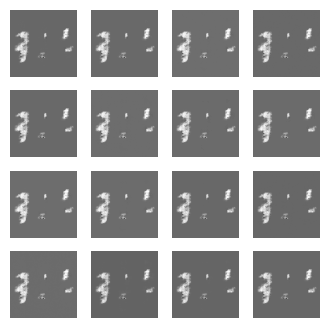

2/2 [==============================] - 0s 9ms/step
Epoch 702/2500 - D Loss: 0.0052, D Acc: 100.00%, G Loss: 5.9917
2/2 [==============================] - 0s 6ms/step
Epoch 703/2500 - D Loss: 0.0029, D Acc: 100.00%, G Loss: 6.4059
2/2 [==============================] - 0s 6ms/step
Epoch 704/2500 - D Loss: 0.0053, D Acc: 100.00%, G Loss: 6.4967
2/2 [==============================] - 0s 6ms/step
Epoch 705/2500 - D Loss: 0.0081, D Acc: 100.00%, G Loss: 5.8833
2/2 [==============================] - 0s 6ms/step
Epoch 706/2500 - D Loss: 0.0104, D Acc: 99.22%, G Loss: 6.1774
2/2 [==============================] - 0s 5ms/step
Epoch 707/2500 - D Loss: 0.0052, D Acc: 100.00%, G Loss: 5.9713
2/2 [==============================] - 0s 6ms/step
Epoch 708/2500 - D Loss: 0.0053, D Acc: 100.00%, G Loss: 5.7594
2/2 [==============================] - 0s 8ms/step
Epoch 709/2500 - D Loss: 0.0069, D Acc: 100.00%, G Loss: 5.6183
2/2 [==============================] - 0s 9ms/step
Epoch 710/2500 - D Loss: 0.009

KeyboardInterrupt: 

In [65]:
train_gan(generator, discriminator, gan, f_train_imgs, latent_dim, epochs, batch_size, display_interval)

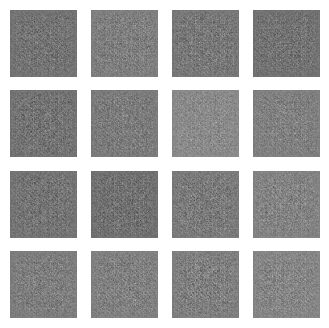

In [23]:
generate_and_visualize(generator, latent_dim)


In [387]:
# Generate synthetic data
num_synthetic_images = 10000
noise = np.random.normal(0, 1, (num_synthetic_images, latent_dim))
synthetic_images = generator.predict(noise)

# print(synthetic_images.shape)
nn_train_imgs = train_imgs.reshape(64000, 45, 45, 1)

# Combine with original training set
augmented_train_images = np.concatenate((nn_train_imgs, synthetic_images))
augmented_train_labels = np.concatenate((train_labels, train_labels[:num_synthetic_images]))


313/313 [==============================] - 2s 5ms/step


In [388]:
# Retrain the best model
history = model.fit(
    augmented_train_images, augmented_train_labels,
    epochs=10,
    batch_size=128,
    validation_data=(cnn_test_imgs, test_labels)
)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential_16/dense_20/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/traitlets/config/application.py", line 1046, in launch_instance

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/cy/t37pw6kj0l3_0306h2px9b_00000gn/T/ipykernel_41866/164482883.py", line 2, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [128,3200], In[1]: [640,512]
	 [[{{node sequential_16/dense_20/Relu}}]] [Op:__inference_train_function_2029422]

In [ ]:
# Evaluate model
test_loss, test_accuracy = model2.evaluate(sp_cnn_test_imgs, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Compare performance
# (Manually compare metrics like accuracy, F1 score, etc. between the original and augmented datasets)


In [464]:
batch_size = 200
epochs = 20000
z_dim = 100

y_train = tf.one_hot(t_train_labels, depth=10, dtype='float32')

# Noise for visualization
z_vis = tf.random.normal([10, z_dim])
y_vis = tf.constant(np.eye(10), dtype='float32')

In [465]:
data_iter = iter(tf.data.Dataset.from_tensor_slices((t_train_imgs, y_train)).shuffle(4 * batch_size).batch(batch_size).repeat())


In [474]:
# Models
def Generator():
  z = tf.keras.layers.Input(shape=(z_dim,), dtype='float32')
  y = tf.keras.layers.Input(shape=(10,), dtype='float32')
  tr = tf.keras.layers.Input(shape=(1,), dtype='bool')

  x = tf.keras.layers.concatenate([z, y])
  x = tf.keras.layers.Dense(3 * 3 * 512)(x)
  x = tf.keras.layers.Reshape((3, 3, 512))(x)
  
  x = tf.keras.layers.Conv2DTranspose(256, 3, 2, 'valid')(x)
  x = tf.nn.leaky_relu(tf.keras.layers.BatchNormalization()(x, training=tr))
  
  x = tf.keras.layers.Conv2DTranspose(128, 4, 2, 'same')(x)
  x = tf.nn.leaky_relu(tf.keras.layers.BatchNormalization()(x, training=tr))
  
  x = tf.keras.layers.Conv2DTranspose(1,  4, 2, 'same', activation='sigmoid')(x)
  x = tf.nn.leaky_relu(tf.keras.layers.BatchNormalization()(x, training=tr))

  out = tf.keras.layers.Reshape((28, 28))(x)
  
  
  return tf.keras.Model(inputs=[z, y, tr], outputs=out)


def Discriminator():
  X = tf.keras.layers.Input(shape=(28, 28), dtype='float32')
  Y = tf.keras.layers.Input(shape=(10,), dtype='float32')
  tr = tf.keras.layers.Input(shape=(1,), dtype='bool')
  
  y = tf.tile(tf.reshape(Y,[-1, 1, 1, 10]), [1, 28, 28, 1])
  x = tf.keras.layers.Reshape((28, 28, 1))(X)
  x = tf.keras.layers.concatenate([x, y])
  
  x = tf.keras.layers.Conv2D(128,  4, 2, 'same')(x)
  
  x = tf.keras.layers.Conv2D(256,  4, 2, 'same')(x)
  x = tf.nn.leaky_relu(tf.keras.layers.BatchNormalization()(x, training=tr))
  
  x = tf.keras.layers.Conv2D(512, 4, 2, 'same')(x)
  x = tf.nn.leaky_relu(tf.keras.layers.BatchNormalization()(x, training=tr))
  
  out = tf.keras.layers.Dense(1)(x)
  
  return tf.keras.Model(inputs=[X, Y, tr], outputs=out)

In [475]:
G = Generator()
D = Discriminator()

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
def G_loss(D, x_fake, y):
  return cross_entropy(tf.ones_like(D([x_fake, y, True])), D([x_fake, y, True]))
def D_loss(D, x_real, x_fake, y):
  return cross_entropy(tf.ones_like(D([x_real, y, True])), D([x_real, y, True])) \
      + cross_entropy(tf.zeros_like(D([x_fake, y, True])), D([x_fake, y, True]))

# Optimizers
G_opt = tf.keras.optimizers.Adam(2e-4)
D_opt = tf.keras.optimizers.Adam(2e-4)

# Train
for epoch in range(epochs):
  z_mb = tf.random.normal([batch_size, z_dim])
  x_real, y = next(data_iter)
  # Record operations
  with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:  
    x_fake = G([z_mb, y, True])
    G_loss_curr = G_loss(D, x_fake, y)
    D_loss_curr = D_loss(D, x_real, x_fake, y)
  # Gradients
  G_grad = G_tape.gradient(G_loss_curr, G.trainable_variables)
  D_grad = D_tape.gradient(D_loss_curr, D.trainable_variables)
  # Apply gradients
  G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
  D_opt.apply_gradients(zip(D_grad, D.trainable_variables))
  
  if epoch % 100 == 0:
    # Print results
    print('epoch: {}; G_loss: {:.6f}; D_loss: {:.6f}'.format(epoch+1, G_loss_curr, D_loss_curr))
    # Plot generated images
    for i in range(10):
      plt.subplot(2, 5, i+1)
      plt.imshow(G([z_vis, y_vis, False])[i,:,:] * 255.0)
      plt.axis('off')
    plt.show()

ValueError: Input 0 of layer "model_7" is incompatible with the layer: expected shape=(None, 28, 28), found shape=(200, 45, 15, 1, 1)